(181, 90, 44)
(181, 180, 88, 1)
[509.70157107]
[-32767.]
[-32767.]
[-32767.]
Combined HR Aux Data Shape: (181, 180, 88, 45)
0.0
65.5
Sliced HR Aux Data Shape: (181, 180, 88, 45)
-5.350948318234112
(180, 88, 7)
最大误差: 8.881784197001252e-16
最大误差: 8.881784197001252e-16
Epoch [1/150], Loss: 0.5235
Epoch [2/150], Loss: 0.5216
Epoch [3/150], Loss: 0.5130
Epoch [4/150], Loss: 0.4852
Epoch [5/150], Loss: 0.4491
Epoch [6/150], Loss: 0.4082
Epoch [7/150], Loss: 0.3972
Epoch [8/150], Loss: 0.3818
Epoch [9/150], Loss: 0.3777
Epoch [10/150], Loss: 0.3708
Epoch [11/150], Loss: 0.3649
Epoch [12/150], Loss: 0.3542
Epoch [13/150], Loss: 0.3467
Epoch [14/150], Loss: 0.3439
Epoch [15/150], Loss: 0.3403
Epoch [16/150], Loss: 0.3330
Epoch [17/150], Loss: 0.3355
Epoch [18/150], Loss: 0.3403
Epoch [19/150], Loss: 0.3402
Epoch [20/150], Loss: 0.3412
Epoch [21/150], Loss: 0.3245
Epoch [22/150], Loss: 0.3198
Epoch [23/150], Loss: 0.3238
Epoch [24/150], Loss: 0.3157
Epoch [25/150], Loss: 0.3114
Epoch [26/150], Lo

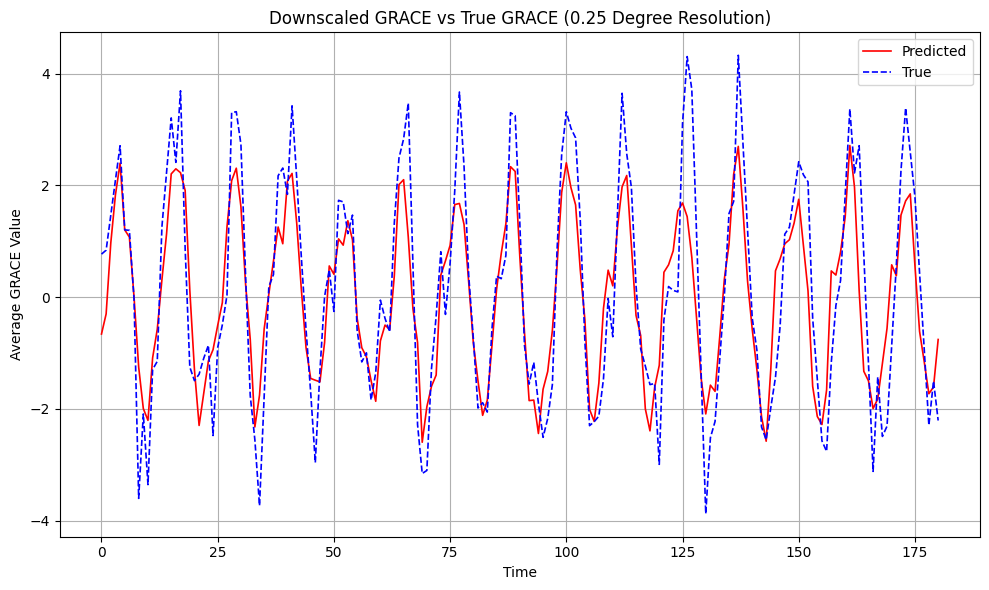

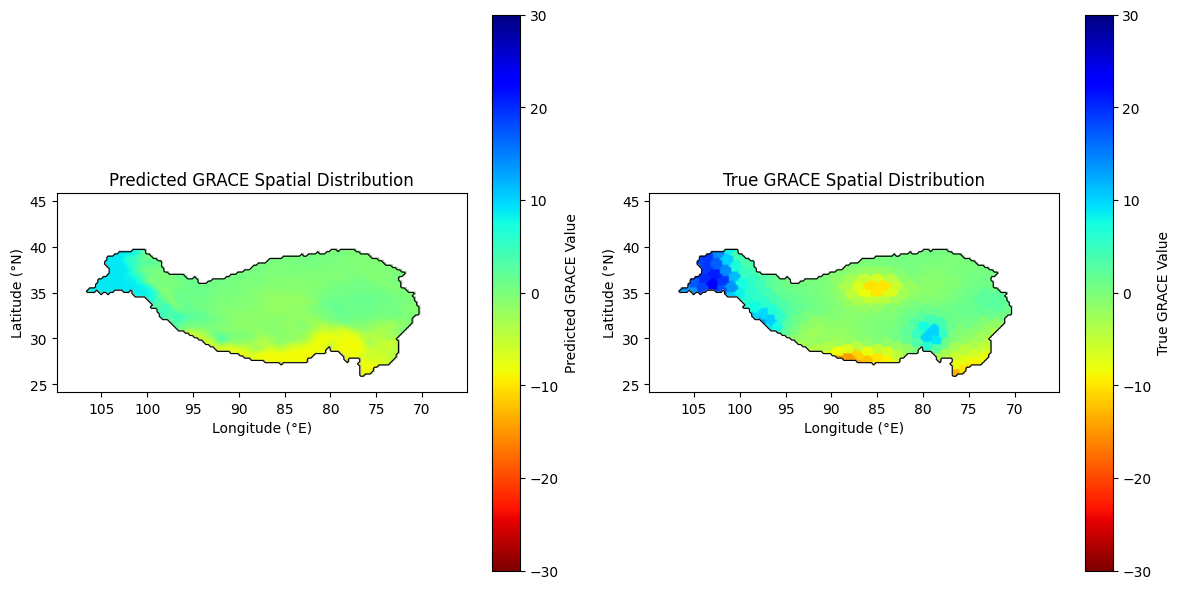

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import h5py
from datasets import load_data

# Load Tibetan Plateau mask
tpb = np.load('tpb_h.npy')

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, hr_aux, grace_025):
        self.hr_aux = hr_aux
        self.grace_025 = grace_025

    def __len__(self):
        return self.hr_aux.shape[0]

    def __getitem__(self, idx):
        hr_aux_item = self.hr_aux[idx]  # Already a tensor
        grace_item = self.grace_025[idx]  # Already a tensor with channel dimension
        return hr_aux_item, grace_item

# Simple Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, output_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Downscale Model
class DownscaleModel:
    def __init__(self, model_class, model_params, epochs=10, batch_size=8, lr=1e-4):
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model_class(**model_params).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self._load_data()

    def _load_data(self):
        # Load your data using the actual load_data function
        [self.lr_grace_05, self.trend05], [self.lr_grace_025, self.trend25], \
        self.hr_aux, self.grace_scaler_05, self.grace_scaler_025, self.aux_scalers = load_data()

        # Use hr_aux at 0.25-degree resolution as-is
        hr_aux_025 = self.hr_aux.transpose(0, 3, 1, 2)  # (batch, channels, height, width)
        hr_aux_025 = torch.tensor(hr_aux_025, dtype=torch.float32)

        # Use grace_025 data as targets
        lr_grace_025 = torch.tensor(self.lr_grace_025, dtype=torch.float32)
        lr_grace_025 = lr_grace_025.unsqueeze(1)  # (batch_size, 1, height, width)

        dataset = CustomDataset(hr_aux_025, lr_grace_025)
        self.dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

    def train(self):
        self.model.train()
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch_idx, (inputs, targets) in enumerate(self.dataloader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            print(f"Epoch [{epoch + 1}/{self.epochs}], Loss: {epoch_loss / len(self.dataloader):.4f}")

    def evaluate(self):
        self.model.eval()
        with torch.no_grad():
            hr_aux_tensor = torch.tensor(self.hr_aux.transpose(0, 3, 1, 2), dtype=torch.float32).to(self.device)
            predicted_grace = self.model(hr_aux_tensor).cpu().numpy()

            # Rescale predictions
            num_samples, _, height, width = predicted_grace.shape
            predicted_grace_reshaped = predicted_grace.reshape(num_samples, -1)
            predicted_grace_rescaled = self.grace_scaler_025.inverse_transform(predicted_grace_reshaped)
            predicted_grace_rescaled = predicted_grace_rescaled.reshape(num_samples, height, width)

            target_grace = self.lr_grace_025
            target_grace_reshaped = target_grace.reshape(num_samples, -1)
            target_grace_rescaled = self.grace_scaler_025.inverse_transform(target_grace_reshaped)
            target_grace_rescaled = target_grace_rescaled.reshape(num_samples, height, width)

            # Apply Tibetan Plateau mask
            predicted_grace_rescaled = np.where(tpb == 1, predicted_grace_rescaled, np.nan)
            target_grace_rescaled = np.where(tpb == 1, target_grace_rescaled, np.nan)

            # Save results to HDF5 file
            with h5py.File('ae_results.h5', 'w') as f:
                f.create_dataset('predicted_grace', data=predicted_grace_rescaled)
            print(f"Saved predicted grace to ae_results.h5 with shape: {predicted_grace_rescaled.shape}")

            self._calculate_metrics(predicted_grace_rescaled, target_grace_rescaled)
            self._plot_results(predicted_grace_rescaled, target_grace_rescaled)
            self._plot_spatial_distribution(predicted_grace_rescaled, target_grace_rescaled)

    def _calculate_metrics(self, predicted, target):
        # Removing NaN values for metrics calculation
        valid_mask = ~np.isnan(predicted) & ~np.isnan(target)
        predicted_valid = predicted[valid_mask]
        target_valid = target[valid_mask]

        nse = 1 - (np.sum((predicted_valid - target_valid) ** 2) / np.sum((target_valid - np.mean(target_valid)) ** 2))
        mae = np.mean(np.abs(predicted_valid - target_valid))
        rmse = np.sqrt(np.mean((predicted_valid - target_valid) ** 2))
        cc = np.corrcoef(predicted_valid.flatten(), target_valid.flatten())[0, 1]
        print(f"NSE: {nse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, CC: {cc:.4f}")

    def _plot_results(self, predicted, target):
        # For plotting, let's average over the spatial dimensions
        predicted_mean = np.nanmean(predicted, axis=(1, 2))
        target_mean = np.nanmean(target, axis=(1, 2))

        plt.figure(figsize=(10, 6))
        plt.plot(predicted_mean, label='Predicted', color='red', linestyle='-', linewidth=1.2)
        plt.plot(target_mean, label='True', color='blue', linestyle='--', linewidth=1.2)
        plt.xlabel('Time')
        plt.ylabel('Average GRACE Value')
        plt.legend()
        plt.title('Downscaled GRACE vs True GRACE (0.25 Degree Resolution)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("grace_downscaling_results.png", dpi=300, bbox_inches="tight")
        plt.show()

    def _plot_spatial_distribution(self, predicted, target):
        sample_idx = 0  # Change to visualize other samples
        vmin, vmax = -30, 30  # Fixed color scale range

        pred_sample = predicted[sample_idx].T  # Transpose for rotation
        true_sample = target[sample_idx].T

        # Define coordinate bounds
        lat_min, lat_max = 24.125, 45.875
        lon_min, lon_max = 65.125, 109.875
        extent = [lon_max, lon_min, lat_min, lat_max]  # Reverse x-axis (lon), normal y-axis (lat)

        plt.figure(figsize=(12, 6))

        # Plot predicted
        ax1 = plt.subplot(1, 2, 1)
        im1 = ax1.imshow(
            pred_sample,
            cmap='jet_r',
            vmin=vmin,
            vmax=vmax,
            extent=extent,
            origin='lower'
        )
        plt.colorbar(im1, ax=ax1, label='Predicted GRACE Value')
        ax1.contour(
            np.isfinite(pred_sample),
            levels=[0.5],
            colors='black',
            linewidths=0.8,
            extent=extent,
            origin='lower'
        )
        ax1.set_title('Predicted GRACE Spatial Distribution')
        ax1.set_xlabel('Longitude (°E)')
        ax1.set_ylabel('Latitude (°N)')

        # Plot true
        ax2 = plt.subplot(1, 2, 2)
        im2 = ax2.imshow(
            true_sample,
            cmap='jet_r',
            vmin=vmin,
            vmax=vmax,
            extent=extent,
            origin='lower'
        )
        plt.colorbar(im2, ax=ax2, label='True GRACE Value')
        ax2.contour(
            np.isfinite(true_sample),
            levels=[0.5],
            colors='black',
            linewidths=0.8,
            extent=extent,
            origin='lower'
        )
        ax2.set_title('True GRACE Spatial Distribution')
        ax2.set_xlabel('Longitude (°E)')
        ax2.set_ylabel('Latitude (°N)')

        plt.tight_layout()
        plt.savefig("spatial_distribution_comparisonAE.pdf", format='pdf', bbox_inches="tight")
        plt.show()

if __name__ == "__main__":
    # Model parameters
    model_params = {
        'input_channels': 45,  # The number of auxiliary data channels
        'output_channels': 1,  # The single channel target
    }

    downscale_model = DownscaleModel(Autoencoder, model_params, epochs=150, batch_size=8)
    downscale_model.train()
    downscale_model.evaluate()
